In [2]:
## from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter


import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

from IPython.display import clear_output

import itertools

from collections import OrderedDict

In [1]:
%store -r da_dv_bhj
%store -r da_bv_bhj
%store -r da_sw_bhj
%store -r da_dcs_bhj 

da_dv = da_dv_bhj
da_bv = da_bv_bhj
da_sw = da_sw_bhj
da_dcs = da_dcs_bhj

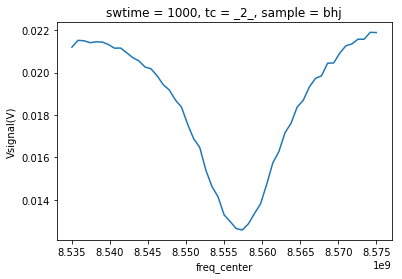

In [4]:

for samp in da_sw.indexes['sample']:
    da1 = da_sw.sel(sample = samp).sel(tc = '_2_')
    for swtime in da1.indexes['swtime']:
        da1.sel(swtime = swtime).dropna('freq','all').plot()

Text(0.5,0,'Frequency (Hz)')

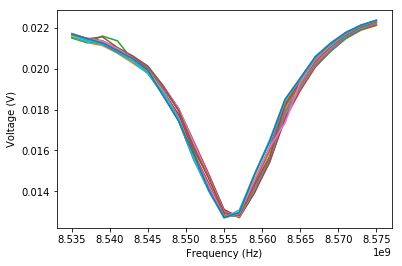

In [5]:
da = da_dcs.sel(direction = 'U')

for freqt in da.indexes['freqt']:
    plt.plot(da.sel(freqt = freqt).to_series())
#     plt.plot(da_bv.sel(sample = 'bhj').sel(direction = 'U').to_series(), color = 'b', marker = 'o')
# plt.legend()
plt.ylabel('Voltage (V)')
plt.xlabel('Frequency (Hz)')

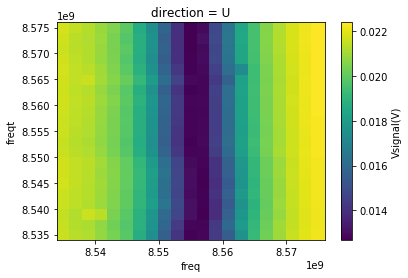

In [6]:
da_dcs.sel(direction = 'U').plot()

In [8]:
data = da_dv.sel(sample = 'bhj').sel(direction = 'U').isel(fluence = -1)

Text(0.5,1,'')

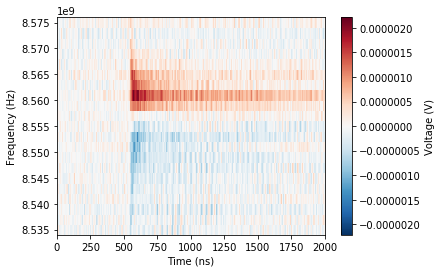

In [9]:
# data = da_dv.sel(sample = 'D (0.001%)', direction = 'U').dropna(dim = 'fluence', how = 'all').isel(fluence = -1).dropna(dim = 'freq', how = 'all')
data.plot(cbar_kwargs={'label': 'Voltage (V)'})
# plt.xlim([200e-9,800e-9])
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
# ax.yaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(9).func))
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (ns)')
ax.set_title('')
# fig = plt.gcf().axes[1].set_label('t')

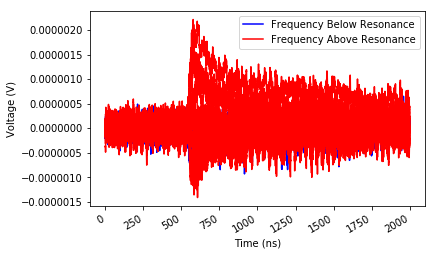

In [10]:
fig, ax = plt.subplots()

freqs = data.indexes['freq']
labeledblue = False
labeledred = False
for freq in freqs:
    if freq < 8.542e9:
        color = 'b'
        if labeledblue:
            label = None
        else:
            label = 'Frequency Below Resonance'
            labeledblue = True
    elif freq > 8.542e9:
        color = 'r'
        if labeledred:
            label = None
        else:
            label = 'Frequency Above Resonance'
            labeledred = True
    elif freq == 8.542e9:
        color = 'g'
        label = 'On resonance'
    trace = data.sel(freq = freq)
    ax.plot(trace.to_series(), color = color, label = label)

ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

# ax.set_xlim(200e-9,500e-9)
# ax.set_ylim([-0.002,0.002])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Voltage (V)')
ax.legend()
fig.autofmt_xdate()


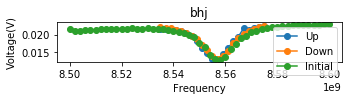

In [18]:
samples = da_bv.indexes['sample']
size = len(samples)
fig, ax = plt.subplots(1,size, figsize = (5*size,1.5*size) , sharey = True)

for i, samp in enumerate(samples):
    swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna(dim = 'freq')
    ax.plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
    swp_bv_d = da_bv.sel(sample = samp, direction = 'D').dropna(dim = 'freq')
    ax.plot(swp_bv_d.indexes['freq'],swp_bv_d,marker = 'o', label = 'Down')
    swp_init = da_sw.sel(sample = samp, tc = '_1_', swtime = 0)
    ax.plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
    ax.set_title(samp)
    ax.legend()
    ax.set_xlabel('Frequency')
    if i == 0: ax.set_ylabel('Voltage(V)') 

    fig.tight_layout()

In [113]:
# v0s_bv = da_bv.sel(direction = 'U')
# v0s_sw = da_sw.sel(tc = '_',swtime = 0).dropna(dim = 'freq')

# # v0_C = da_bv.sel(sample = 'C' , direction = 'D')
# v0_C =  da_sw.sel(sample = 'C (0.01%)', tc = '_',swtime = 0).dropna(dim = 'freq')
# v0_A = da_bv.sel(sample = 'A (0%)' , direction = 'D')
# v0_A = v0_A.fillna(0.02164)
# v0_D = da_bv.sel(sample = 'D (0.001%)' , direction = 'U')
# v0_D = v0_D.fillna(0.02135)

# v0_C_i = da_bv.sel(sample = 'C (0.01%)' , direction = 'D')
# v0_C_i.loc[:] = np.interp(v0s_bv.indexes['freq'],v0_C.indexes['freq'],v0_C.values )
# # v0_C_i.set_index({'sample': 'C'})

# v0s = xr.concat([v0_C_i, v0_A, v0_D], dim = 'sample').drop('direction')

In [21]:
v0 = da_dcs.sel(direction = 'U').isel(freqt = 0)

v0_i = v0.copy(deep = True)
v0_i = v0_i.assign_coords(freq =da_dv.indexes['freq'] )
v0_i.loc[:] = np.interp(da_dv.indexes['freq'],v0.indexes['freq'],v0.values )
v0_i = v0_i.assign_coords(sample = 'bhj').expand_dims('sample').drop('direction').drop('freqt')
# v0s = xr.concat([v0], dim = 'sample')
v0s = v0_i

<xarray.DataArray 'Vsignal(V)' (sample: 1, freq: 21)>
array([[0.021559, 0.021362, 0.021248, 0.020805, 0.020411, 0.019862, 0.018735,
        0.017492, 0.015579, 0.014174, 0.012743, 0.01282 , 0.014394, 0.015543,
        0.017587, 0.019225, 0.020295, 0.020949, 0.021564, 0.021941, 0.022184]])
Coordinates:
  * freq     (freq) float64 8.535e+09 8.537e+09 ... 8.573e+09 8.575e+09
  * sample   (sample) <U3 'bhj'

In [22]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = 8.555e9
    p0 =[f0,1e7,0.01, Rinf]
    p_labels = ['f0','w','R','Rinf'] 
    epsilon = 0.00001
#     bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 100

elif fittype == 'poly':
    window = 2
    p_labels = ['R', 'f0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]


In [23]:
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_sw.sel(tc = '_2_',swtime = 0).isel(freq = 0).drop('tc').drop('swtime').drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)


K sample bhj = 66385.49502230163


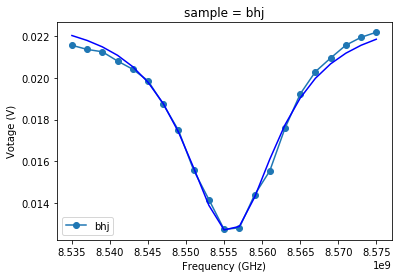

In [24]:
v0_fits = v0s.copy()

samples = v0s.indexes['sample']
freqs_i = da_dv.indexes['freq']
mi = pd.MultiIndex.from_product([samples,freqs_i], names = ['sample', 'freq'])
s = pd.Series(index = mi)
v0s_i = xr.DataArray.from_series(s)

Ks = pd.Series(index = samples)
for samp in v0s.indexes['sample']:
    v0 = v0s.sel(sample = samp)
    dv = da_dv.sel(sample = samp, direction = 'U', time = 0).dropna(dim = 'fluence', how = 'all').isel(fluence = -1).dropna(dim = 'freq')
    freqs = dv.indexes['freq']
    
    v0s_i.loc[samp] = v0.interp(freq = freqs).reindex(freq = freqs_i)
    
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    freqs = v0s.indexes['freq'][v0_sl]
    v0_fits.loc[samp] = v0_fit(freqs)
    
    v0s_i.loc[samp].plot(marker = 'o', label = samp)
    v0_fits.loc[samp].plot(color = 'b')
    
    for i, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp] = v0_p[i]
    
    Ks[samp] = analysis.calc_K(f0 = v0_p[0], w = v0_p[1], R0 = v0_p[2]/v0_p[3], printparams = False)
    print('K sample ' + samp + ' = ' + str(Ks.loc[samp]))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Votage (V)')
plt.legend()

In [25]:
time1 = 500e-9
time2 = 2000e-9
step = 20

times = da_dv.indexes['time']
timesel1 = pd.Series(abs(times-time1)).idxmin()
timesel2 = pd.Series(abs(times-time2)).idxmin()

times = times[slice(timesel1,timesel2,step)]

In [26]:
ds_p_r  =  ds_p.sel(direction = 'U').drop(['direction']).sel(time = times).copy(deep = True)
dvs = da_dv.sel( direction = 'U').dropna(dim = 'freq', how = 'all').sel(time = times)

# dvs
vss = v0s + dvs
fits = vss.copy(deep = True)

cds = ds_p_r.coords

num = len(cds['fluence'])*len(cds['sample'])*len(cds['time'])
i=0

for samp in vss.indexes['sample']:
    vs1 = vss.sel(sample = samp).dropna('fluence','all')   
    for flu in vs1.indexes['fluence']:
        vs2 = vs1.sel(fluence = flu).dropna('time','all')
        for time in vs2.indexes['time']:
            i=i+1
            clear_output(wait = True)
            print(str((i/num)*300) + ' %') #Not sure where this factor of 3 is coming from, see num above. 
            
            vs3 = vs2.sel(time = time).dropna('freq')
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)

            freqs = vs2.indexes['freq'][vs_sl]
            fits.loc[samp,:,flu,time] = vs_fit(freqs).values
            ds_p_r['f0'].loc[samp,flu,time] = vs_p[0]
            ds_p_r['w'].loc[samp,flu,time] = vs_p[1]
            ds_p_r['R'].loc[samp,flu,time] = vs_p[2]
            ds_p_r['Rinf'].loc[samp,flu,time] = vs_p[3]
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)

300.0 %


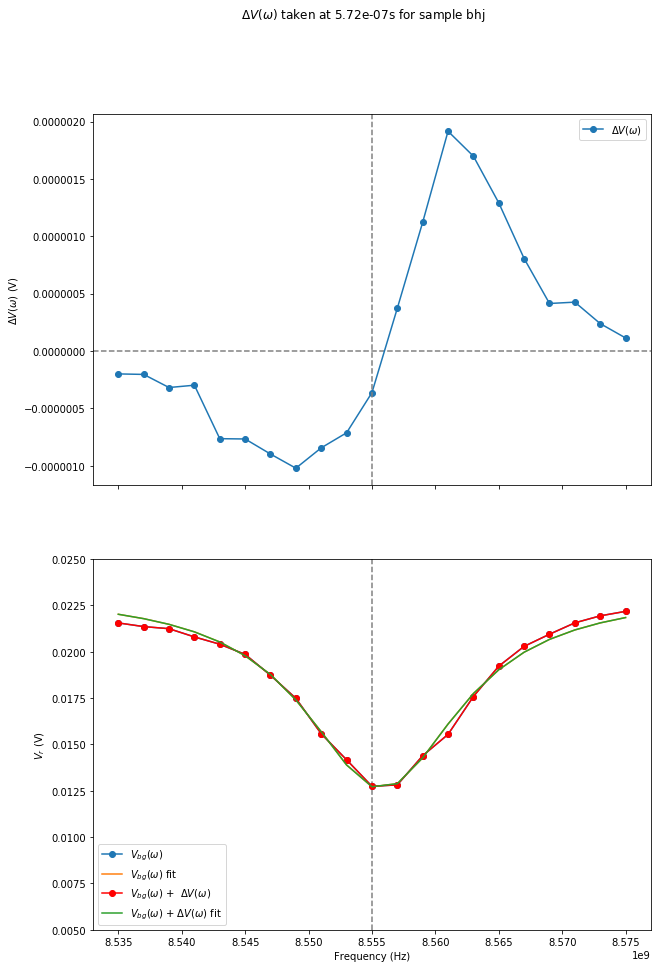

In [27]:
samp = 'bhj'

dst = ds.sel(sample = samp).dropna('fluence','all').isel(fluence = -1)
v0 = v0s_i.sel(sample = samp)

fig, axes = plot.vsplotxr(570, dst['dvs'], vss= dst['vss'], fits = dst['fits'], v0 = v0, v0_fit = v0_fits.loc[samp])

axes[1].set_ylim([0.005,0.025])
for ax in axes:
    ax.legend()

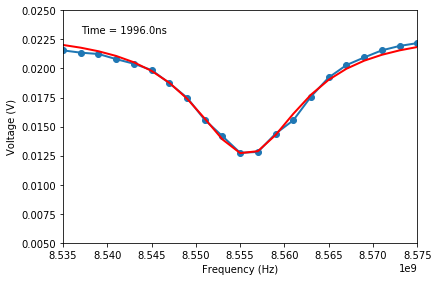

In [28]:
plot.sweepfitanim(dst)

In [30]:
ds = ds.assign_coords(sample = ['bhj'])
ds_p_r = ds_p_r.assign_coords(sample = ['bhj'])

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\matplotlib\ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


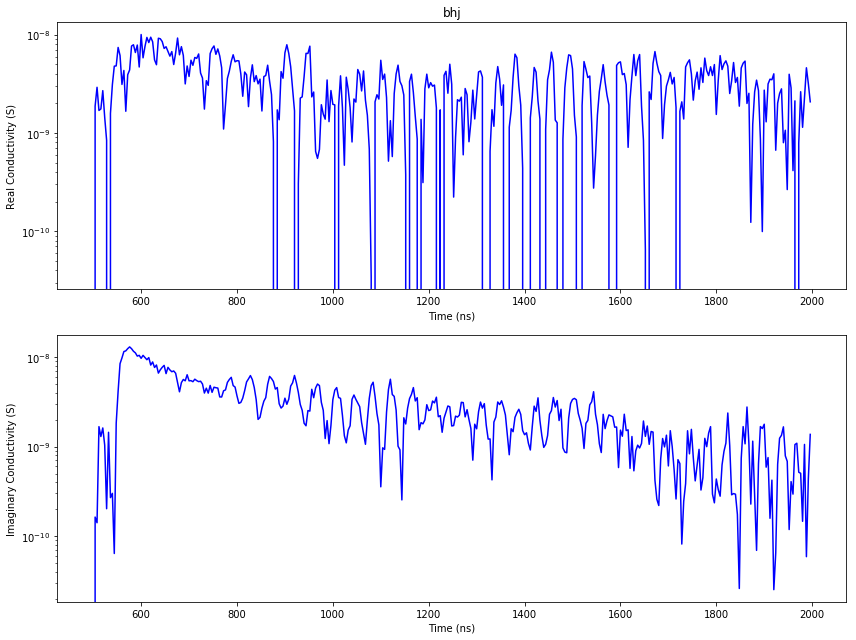

In [40]:
fig, axes = plt.subplots(2,len(ds.indexes['sample']), figsize = (12,9))
# axes= [axes]
e0 = 8.854e-12
F=1

ft = ds_p_r['f0']
f0 = ft.isel(time = 0)
deltaf = abs(ft-f0)
sig_I_a = -1*deltaf*e0/F

wt = ds_p_r['w']
w0 = wt.isel(time = 0)
deltaFWHM = wt - w0
sig_R_a = deltaFWHM*e0/(2*F)


for i , samp in enumerate(ds_p_r.indexes['sample']):
    sig_Rs = sig_R_a.sel(sample = samp).dropna('fluence','all').copy(deep = True)
    sig_Is = sig_I_a.sel(sample = samp).dropna('fluence','all').copy(deep = True)
    for fluence in sig_Rs.indexes['fluence']:
        sig_R = sig_Rs.sel(fluence = fluence)
        sig_I = sig_Is.sel(fluence = fluence)

        label = '$\sigma^{\'}(\Delta FWHM)$'

        ax = axes[0]#[i]
        sig_R = sig_R.to_series()
        if np.trapz(sig_R) < 0:
            color = 'b'
            sig_R = sig_R*-1
        else:
            color = 'r'
        ax.plot(sig_R, label = label, color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Real Conductivity (S)')

        ax = axes[1]#[i]
        sig_I = sig_I.to_series()
        if np.trapz(sig_I) < 0:
            color = 'b'
            sig_I = sig_I*-1
        else:
            color = 'r'
        ax.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$', color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Imaginary Conductivity (S)')

    ax = axes[0]#[i]
    ax.set_title(samp)
for ax in axes:
#     for ax in axs:
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
#         axes.set_xlim(250e-9,1200e-9)
    ax.set_xlabel('Time (ns)')

        # axes.set_ylim([1e-8,1e-4])

fig.tight_layout()

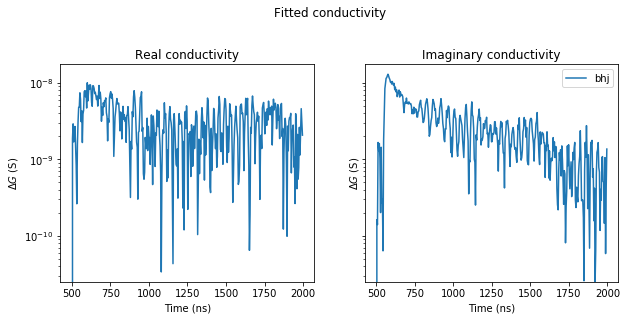

In [41]:
# res = g.sel(freq = 8.5420e9, method = 'nearest')

fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = True)

for sample in ds.indexes['sample']:
    sel = sig_R_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    axes[0].plot(abs(sel.to_series()), label = sample)
    axes[0].set_title('Real conductivity')
    sel = sig_I_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    axes[1].plot(abs(sel.to_series()), label = sample)
    axes[1].set_title('Imaginary conductivity')

for ax in axes:
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('$\Delta G$ (S)')
        
        
fig.suptitle('Fitted conductivity', y = 1.08)
ax.legend()

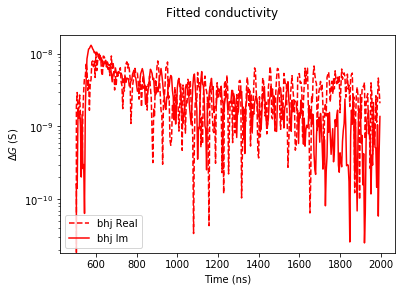

In [42]:
# res = g.sel(freq = 8.5420e9, method = 'nearest')

fig, ax = plt.subplots()

colors = ['r','g','b']

for i, sample in enumerate(ds.indexes['sample']):
    sigr = sig_R_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    sigi = sig_I_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    ax.plot(abs(sigr.to_series()), label = sample + " Real", linestyle = '--', color = colors[i])
    ax.plot(abs(sigi.to_series()), label = sample + " Im", color = colors[i])    
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
        
ax.set_xlabel('Time (ns)')
ax.set_ylabel('$\Delta G$ (S)')
        
fig.suptitle('Fitted conductivity')
ax.legend()